1. Índice
1. Selección de los datos de interés a analizar
1. Lectura del archivo y descripción del dataset
1. Limpieza de los datos

    4.1 Elementos duplicados

    4.2 Elementos nulos o vacíos

    4.3 Valores extremos

1. Análisis exploratorio 

    5.1 Análisis descriptivo
    
    5.2 Análisis estadístico

    5.2.1 Comprobación de la normalidad y homogeneidad de la varianza
        
    5.2.2 Aplicación de pruebas estadísticas
        
1. Conclusiones

Ejemplo de índice final para cuando ya esté todo mergeado:

1. [Introducción](#intro)
1. [Second Bullet Header](#second-bullet)

# 1. Introducción <a class="anchor" id="intro"></a>

El siguiente documento recoge la realización de la Práctica 2 de la asignatura Tipología y ciclo de vida de los datos. En ella se elabora un caso práctico orientado a aprender a identificar los datos relevantes para un proyecto analítico y usar las herramientas de integración, limpieza, validación y análisis de las mismas. En ella se pondrán en práctica los conceptos aprendidos durante todo el semestre de la asignatura, realizando un análisis exploratorio de un dataset seleccionado y aplicando técnicas de análisis de datos.

La práctica ha sido realizada por **Alicia Contreras** y **Daniel García**.

# 2. Selección de los datos de interés a analizar

El dataset elegido para esta práctica ha sido *Spaceship Titanic*. Se trata de una de las competiciones de la página web Kaggle.

https://www.kaggle.com/competitions/spaceship-titanic

Se ha elegido este conjunto de datos ya que cumple con las características esperadas para plantear con él una tarea de ciencia de datos. El dataset es facilmente accesible, ya que los datos pueden descargarse directamente desde la página web de Kaggle. La información acerca de las variables del dataset y del objetivo de la competición están explicados con detalle. La variabilidad de la información que tenemos (variables categóricas, numéricas y booleanas) nos ha permitido realizar un análisis exploratorio de los datos completo y en profundidad. Por último, la temática de la competición nos ha parecido interesante y el hecho de realizar el análisis exploratorio para esta práctica nos servirá para realizar los primeros pasos de cara a participar en la competición.


# 3. Lectura del archivo y descripción del dataset

A continuación se detalla el dataset de *Spaceship Titanic*. Se trata de una serie de datos de casi 13.000 pasajeros de una nave espacial en el año 2912, encargada de transportar emigrantes del sistema solar a tres exoplanetas habitables. Esta nave ha tenido un incidente por el cual gran parte de los pasajeros han sido enviados a otra dimensión.

El dataset contiene una variable objetivo que nos indica si un pasajero ha sido transportado a otra dimensión o no, con el objetivo de utilizar técnicas de ciencia de datos para predecirlo y evitar futuros desastres. 

Este dataset está compuesto por un total de 14 variables de las cuales encontramos

- Texto: 2 (una de ellas un identificador único de pasajero)
- Categóricas: 3
- Numéricas: 6
- Binarias: 3 (de las cuales una es la variable objetivo)

La descripción de estas variables se detalla a continuación.

- **PassengerId**: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet**: The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep**: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin**: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination**: The planet the passenger will be debarking to.
- **Age**: The age of the passenger.
- **VIP**: Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name**: The first and last names of the passenger.
- **Transported**: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


In [272]:
# Importamos las librerías necesarias
import numpy as np
#from ggplot import ggplot, aes, geom_bar, theme_bw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import networkx as nx

import statsmodels.api as sm
import scipy

En la página fuente del dataset se proporcionan ya separados los datos de training y test. Sin embargo, de cara a realizar un EDA se realizará una unión de ambos subgrupos para formar un único dataset. Los datos del subconjunto de *test* no cuentan con información acerca de la variable objetivo por lo que aquellos análisis que incluyan la variable objetivo se realizarán únicamente en el conjunto de *training*.

In [96]:
titanic_train = pd.read_csv("data/train.csv")
titanic_test = pd.read_csv("data/test.csv")

titanic = pd.concat([titanic_train, titanic_test])

In [97]:
titanic.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [98]:
# Separamos las diferentes variables para futuros análisis

col_numeric = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
col_categoric = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
target = 'Transported'

titanic.shape

(12970, 14)

El datasete stá formado por un total de 12.970 registros y contiene 14 columnas. Queremos saber cuales de esas columnas tienen valores vacíos.

# 4. Limpieza de datos

En el siguiente apartado procederemos a realizar un análisis para ver si es necesario realizar una limpieza de datos.

## 4.1 Elementos duplicados

En primer lugar, comprobaremos si existen elementos duplicados en el dataset. Para ello utilizaremos la columna **PassengerId**. Se trata de un identificador único de cliente según las especificaciones del dataset. Vemos que esto se cumple, ya que no existe duplicidad en la columna. El resto de elementos del dataset si podrían estar duplicados por lo que con esta columna nos bastaría para ver que efectivamente, no existe duplicidad de registros.

In [99]:
titanic[titanic["PassengerId"].duplicated() == True].size


0

In [100]:
# Una vez comprobado que no se han duplicado los datos, prescindimos de la columna Name
# por no aportar información útil más allá de ser identificativa.
for df in [titanic, titanic_train, titanic_test]:
    df = df.drop(['Name'], axis=1)

## 4.2 Valores extremos

A continuación queremos comprobar la existencia de valores extremos, ya que esto puede afectar en gran medida el análisis posterior.

<AxesSubplot:xlabel='VRDeck'>

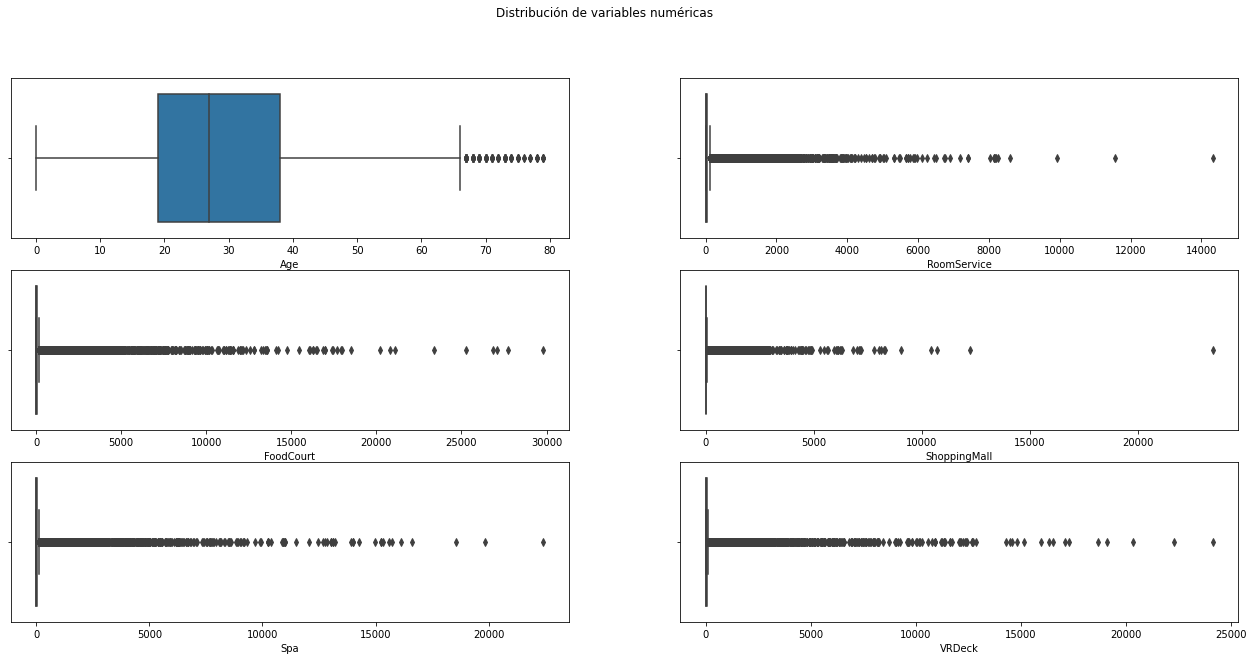

In [101]:
fig, axes = plt.subplots(3, 2, figsize=(22, 10))

fig.suptitle('Distribución de variables numéricas')


sns.boxplot(ax=axes[0, 0], data=titanic, x='Age')
sns.boxplot(ax=axes[0, 1], data=titanic, x='RoomService')
sns.boxplot(ax=axes[1, 0], data=titanic, x='FoodCourt')
sns.boxplot(ax=axes[1, 1], data=titanic, x='ShoppingMall')
sns.boxplot(ax=axes[2, 0], data=titanic, x='Spa')
sns.boxplot(ax=axes[2, 1], data=titanic, x='VRDeck')

Tal y como podemos ver en la representación de los boxplots de las variables numéricas, existen gran cantidad de valores considerados *atípicos* en las relacionadas con las cantidades de dinero gastadas por los clientes. Podría considerarse eliminar los valores a partir de un rango, pero sin embargo, teniendo en cuenta el dominio del problema y al tratarse de cantidades monetarias se puede asumir que realmente hay clientes con mucho dinero que pueden asumir esa clase de gastos. En relación a la variable "age", los valores considerados atípicos en el boxplot están dentro del rango de edades posibles para una persona, por lo que los mantendremos. Los únicos valores que no podrían ser válidos serían menos que 0, pues significaría que les han pagado por utilizar los servicios o que hay personas que menos de 0 años.

In [102]:

titanic[titanic[col_numeric] < 0][col_numeric].sum()

Age             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

No se realizará por tanto ningún tratamiento extra de los valores atípicos.


## 4.3 Elementos nulos o vacíos

Finalizaremos por realizar un análisis sobre los elementos nulos existentes en el dataset, en qué medida afectan y si es necesario tratarlos.

In [103]:
titanic.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

Por lo general parece que existe una gran cantidad de valores nulos en las columnas, a pesar de que no supone un número excesivamente alto con respecto al total de registros. Tal y como observamos a continuación, no hay muchas columnas con más de 3 valores nulos. 

In [104]:
titanic[titanic.isna().sum(axis=1) > 3]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
488,1050_01,NaN,True,G/157/P,TRAPPIST-1e,NaN,False,0.0,0.0,NaN,0.0,0.0,Evendy Buchansen,NaN
1192,2501_01,Europa,True,C/90/S,TRAPPIST-1e,47.0,False,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2042,4412_01,Earth,False,F/907/P,NaN,19.0,NaN,9.0,3.0,0.0,1390.0,NaN,Roydo Mayson,NaN
3858,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,1216.0,NaN,NaN


Para un mejor tratamiento de los datos en un futuro, se realizará una sustitución de valores en las variables booleanas.

In [105]:
# Sustituimos valores de True-False por 1 o 0
titanic_train["CryoSleep"] = titanic_train["CryoSleep"].map(lambda x: 1 if x==True else 0)
titanic_train["VIP"] = titanic_train["VIP"].map(lambda x: 1 if x==True else 0)
titanic_train["Transported"] = titanic_train["Transported"].map(lambda x: 1 if x==True else 0)

titanic_test["CryoSleep"] = titanic_test["CryoSleep"].map(lambda x: 1 if x==True else 0)
titanic_test["VIP"] = titanic_test["VIP"].map(lambda x: 1 if x==True else 0)


titanic = pd.concat([titanic_train, titanic_test])


Teniendo en cuenta las características del dataset, se han tomado las siguientes decisiones de diseño sobre el tratamiento de valores nulos:

- Los registros que no contengan la variable numérica **Age** se reemplazarán los valores nulos por la media de edad de todos los pasajeros de la nave.
- Las variables numéricas relacionadas con los gastos de los pasajeros en los dervicios de lujo de la nave **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck** se sustituirán por $0$. Se asumirá que los clientes que no tengan información en estas variables es porque no se han gastado nada en ellos.
- Para las variables categóticas se mantendrán los nulos, ya que el hecho de que los valores estén a nulo puede ofrecernos información importante. En las variables no booleanas **HomePlanet**, **CryoSleep**, **Cabin** y **Destination** se sustituirán los nulos por la etiqueta "Desconocido".

In [106]:
# Sustituimos en la variable Age

titanic["Age"]=titanic["Age"].fillna(titanic["Age"].mean())

# En el resto de variables numéricas

titanic['RoomService']=titanic['RoomService'].fillna(0)
titanic['FoodCourt']=titanic['FoodCourt'].fillna(0)
titanic['ShoppingMall']=titanic['ShoppingMall'].fillna(0)
titanic['Spa']=titanic['Spa'].fillna(0)
titanic['VRDeck']=titanic['VRDeck'].fillna(0)

# Y finalmente en las variables categóricas

titanic['HomePlanet']=titanic['HomePlanet'].fillna("Origen desconocido")
titanic['CryoSleep']=titanic['CryoSleep'].fillna("Desconocido")
titanic['Cabin']=titanic['Cabin'].fillna("Desconocido")
titanic['Destination']=titanic['Destination'].fillna("Destino desconocido")



titanic.isna().sum()


PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
dtype: int64

# 5. Análisis exploratorio 

## 5.1. Análisis descriptivo

En esta sección realizaremos un análisis gráfico y comparativo de las diferentes variables del dataset. Comenzaremos por el análisis de las distribuciones de las variables numéricas y las categóricas de manera individual, para intentar comprender mejor los rangos y los valores de las variables así como su distribución. Se realizarán comparaciones y agrupaciones de algunas variables para intentar extraer conclusiones conjuntas. Finalmente se hará un estudio comparativo de algunas de las variables en base a la variable objetivo **Transported**, para tratar de encontrar diferencias y similitudes ambos grupos de personas: los que han sido transportados a otra dimensión y los que no.

En primer lugar, analizaremos el objetivo del viaje en transbordador, que es viajar a otro planeta. Tenemos la información del planeta de origen de cada pasajero así como el planeta al que viaja.

<AxesSubplot:xlabel='Destination', ylabel='count'>

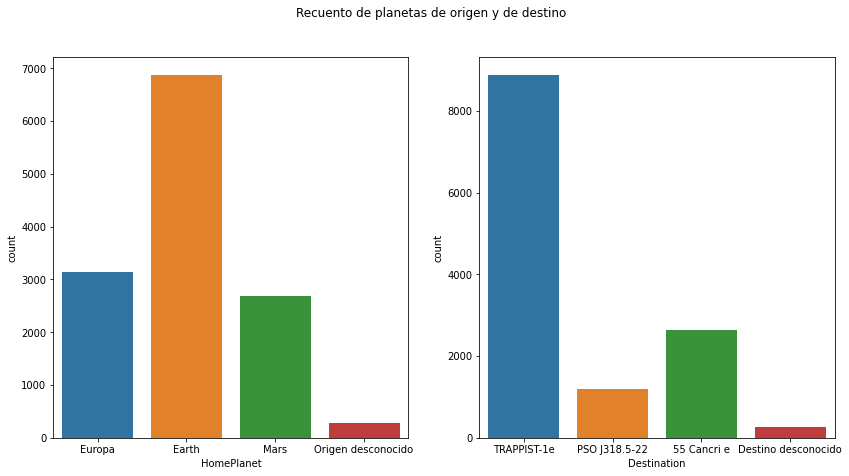

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

fig.suptitle('Recuento de planetas de origen y de destino')


sns.countplot(ax=axes[0], data=titanic, x='HomePlanet')
sns.countplot(ax=axes[1], data=titanic, x='Destination')

Podemos ver que la gran mayoría de pasajeros provienen del planeta Tierra, *Earth*. El resto provienen de los planetas *Europa* y *Marte*, en proporciones similares. Existe una pequeñá porción de pasajeros de los que se desconoce su planeta de proveniencia. En cuanto a los planetas de destino, podemos ver que el más común con diferencia al que se dirige la gente es *TRAPPIST-1e*. Existe bastante diferencia con respecto a los otros dos planetas. También existe un número reducido de personas de las que se desconoce el destino al que se dirigen. Es extraño el hecho de que existan personas de las que se desconocen estos datos, ya que se entiende que el único motivo de viajar en esta nave es trasladarse a otro planeta. POdría tratarse sin embargo de los empleados de la tripulación o el personal de la nave.

Queremos observar también las combinaciones más típicas entre origen y destino, para lo cual representaremos los valores en un grafo relacional.

In [108]:
df = titanic[['HomePlanet', 'Destination']]

destination_graph=df.value_counts().reset_index()
destination_graph.columns = ['HomePlanet', 'Destination', 'Total']
#destination_graph['Type'] = np.where(destination_graph['HomePlanet']== '[]', True, False)
destination_graph=destination_graph.sort_values(by=['Total'])

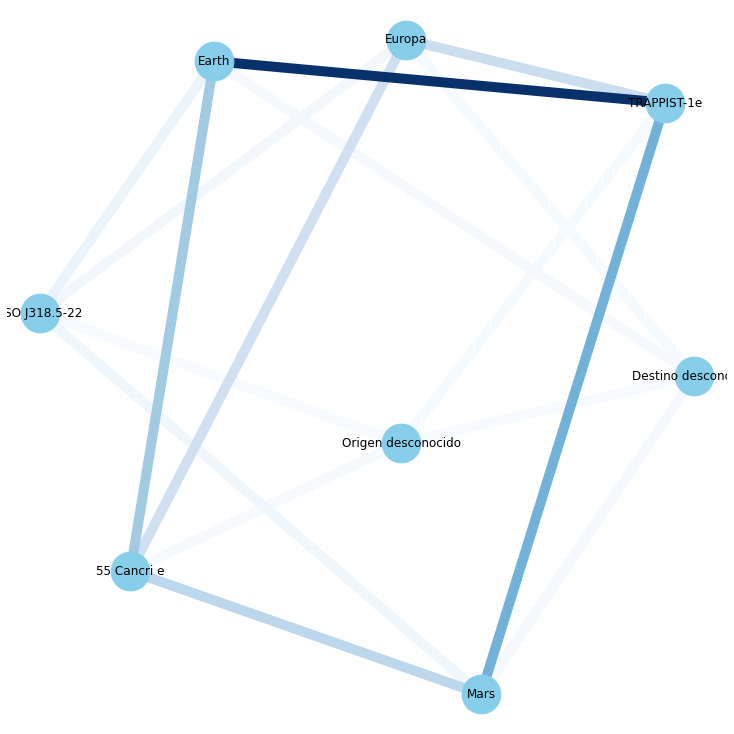

In [109]:
plt.figure(3,figsize=(10,10)) 

G=nx.from_pandas_edgelist(destination_graph, 'HomePlanet', 'Destination', create_using=nx.Graph() )
 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color=destination_graph['Total'], width=10.0, edge_cmap=plt.cm.Blues)
plt.show()

El grafo representa el conteo de origen-destino por tonalidades de color, cuanto más oscuro más concurrido. Vemos que como era de esperar, el planeta de partida más común, *Earth* coincide con el planeta de destino más común *TRAPPIST-1e* como combinación de viaje más concurrida. El segundo destino más común para personas que habitan en la Tierra es el planeta *55 Cancri e*. 

También existe mucha gente que viaja desde Marte a *TRAPPIST-1e*, con *55 Cancri e* como segunda opción de destino. Por lo que parece, el planeta *PSO J318 5-22* no es un destino tan llamativo como los otros dos planetas. En el caso de las personas de las que no sabemos su destino y/o su origen, se puede apreciera que no son un número grande.

También nos interesa saber la distribución de edad en función del destino. Hay algún destino que sea preferido por gente mayor o por gente joven?

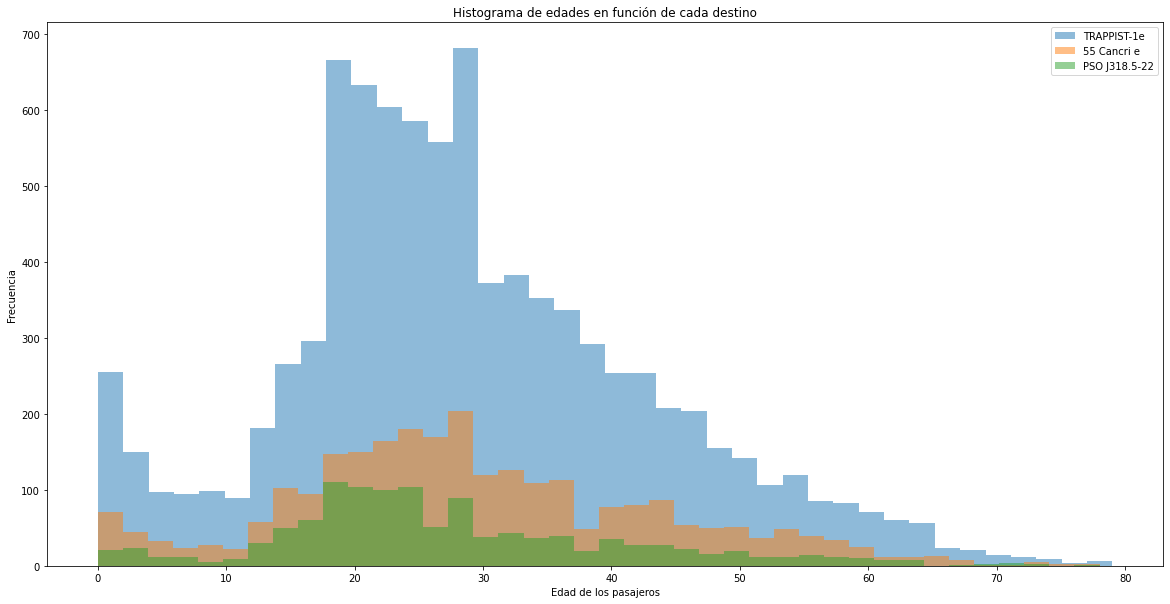

In [110]:
plt.figure(3,figsize=(20,10)) 

plt.hist(titanic['Age'][titanic['Destination']=="TRAPPIST-1e"], alpha=0.5, density=False, bins=40, label="TRAPPIST-1e")
plt.hist(titanic['Age'][titanic['Destination']=="55 Cancri e"], alpha=0.5, density=False, bins=40, label="55 Cancri e")
plt.hist(titanic['Age'][titanic['Destination']=="PSO J318.5-22"], alpha=0.5, density=False, bins=40, label="PSO J318.5-22")
plt.ylabel('Frecuencia')
plt.xlabel('Edad de los pasajeros')
plt.title("Histograma de edades en función de cada destino")
plt.legend(loc='upper right')
plt.show()

Por lo que podemos ver, los tres destinos tienen exactamente la misma forma. Los tres tienen la misma distribución. Esto puede indicarnos que no existe ningún motivo por el cual una persona más joven o más mayor prefiera irse a un planeta o a otro, y que al parecer es común que las familias viajen juntas y por tanto haya distribuciones muy similares en los tres. 

Entre los pasajeros con destino a los tres planetas se puede observar que exite un pico de niños recien nacidos, que se reduce bastante entre las edades de entre los 3 y los 11 años. Se observa un gran aumento de densidad de población en las edades de entre 19 y 29 años, con un pico en este último año de edad muy acusado y que destaca por encima del resto de franjas de edad en los tres planetas de destino. Con respecto al resto de edades, podemos ver cómo la frecuencia va disminuyendo suavemente hasta llegar a los 80 años, el máximo de la edad de las personas del dataset.


La variable **Cabin** representa el número de camarote en el que se hospeda cada pasajero de la forma *deck/num/side* (cubierta/número/lado). Los lados pueden ser:

- **P**: Babor (parte izquierda de la nave)
- **S**: Estribor (parte derecha de la nave)

Queremos comparar el nivel económico de los pasajeros que se alojan a ambos lados de la nave. Para ello crearemos una nueva variable partiendo de **Cabin**.

In [111]:
titanic["Side"] = np.where(titanic["Cabin"] != 'Desconocido', titanic["Cabin"].str[-1:], titanic["Cabin"])
titanic["Side"][titanic["VIP"]==1].value_counts()

P              142
S              124
Desconocido      7
Name: Side, dtype: int64

In [112]:
df = titanic[['Side', 'VIP']]

bars=df.value_counts().reset_index()
bars.columns = ['Side', 'VIP', 'Total']
bars[bars['VIP']==1]

,Side,VIP,Total
3,P,1,142
4,S,1,124
5,Desconocido,1,7


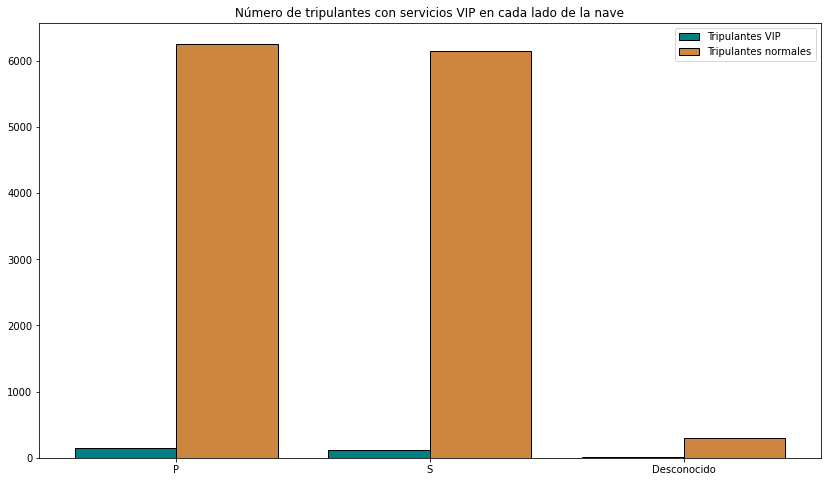

In [113]:
plt.figure(3,figsize=(14,8)) 

x = np.arange(3)

plt.bar(x-0.2, bars['Total'][bars['VIP']==1], color='teal', width=0.4, edgecolor='black', label='Tripulantes VIP')
plt.bar(x+0.2, bars['Total'][bars['VIP']==0], color='peru', width=0.4, edgecolor='black', label='Tripulantes normales')
plt.xticks(x,['P', 'S', 'Desconocido'])
plt.title('Número de tripulantes con servicios VIP en cada lado de la nave')

plt.legend()
plt.show()


Tal y como podemos observar, la cantidad de tripulantes que han contratado los servicios VIP del crucero son muy pocos, por lo que tampoco se aprecian comparaciones destacables. Si que podemos ver sin embargo que hay más personas que han contratado los servicios VIP alojadas en babor que en estribor. La mayoría de la gente de la que desconocemos el lado en el que se aloja no ha contratado estos servicios. 

Vamos a ver si esta tendencia ocurre también a la hora de la contratación de otros servicios en la nave. Para ello crearemos una variable **Total_spent** que será la suma de gastos en los servicios **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck**. 

In [114]:
titanic["Total_spent"] = titanic[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
titanic[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck","Total_spent"]].head(3)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_spent
0,0.0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0,736.0
2,43.0,3576.0,0.0,6715.0,49.0,10383.0


<AxesSubplot:title={'center':'Dinero gastado en servicios por los tripulantes VIP y no VIP en cada lado de la nave'}, xlabel='Side', ylabel='Total_spent'>

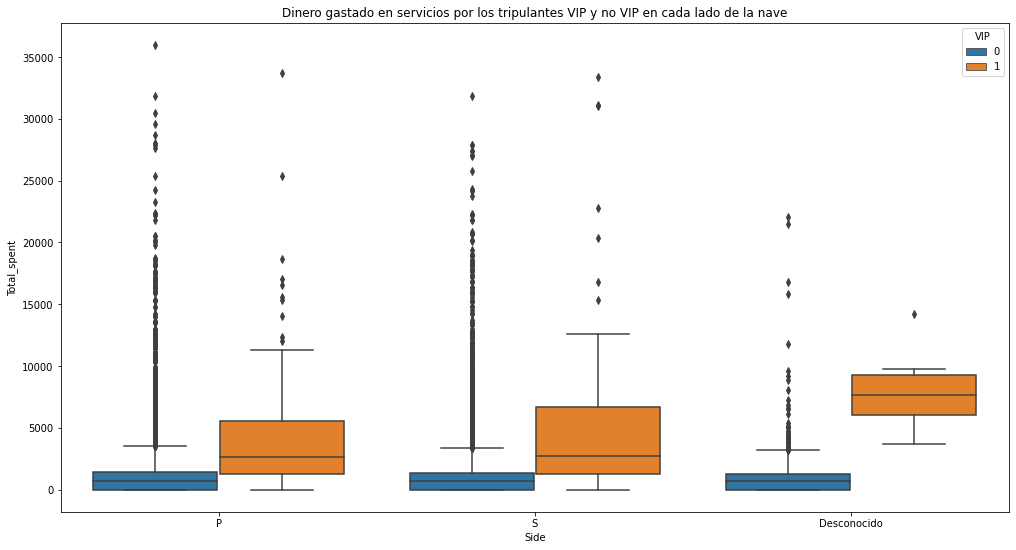

In [115]:
plt.figure(3,figsize=(17,9))
plt.title('Dinero gastado en servicios por los tripulantes VIP y no VIP en cada lado de la nave')

sns.boxplot(x='Side', y='Total_spent', hue='VIP', data=titanic)

Como era de esperar, las personas que han contratado los servicios VIP de la nave suelen gastarse cantidades más altas de dinero en actividades complementarias, por lo que se entiende que se trata de tripulantes con un poder adquisitivo alto. Para cualquiera de los lados de camarotes de la nave, el 75% de personas no VIP se han gastado lo mismo que el 25% de personas VIP. Esto quiere decir que los gastos de las personas VIP son bastante superiores a los de las personas no VIP independientemente del lado en el que se alojen. El nivel adquisitivo de ambos lados de la nave parece ser similar aunque las personas que se alojan en la parte de estribor (S) despuntan un poco por arriba, por lo que suelen gastarse un poco maś. Contrastando esta información con el recuento anterior de personas VIP, llegamos a la conclusión de que en el lado de estribor, a pesar de haber un menor número de personas VIP, suelen gastarse más en servicios.

En esta misma línea, nos interesa saber el dinero gastado en diferentes servicios por los tripulantes según su destino y su origen.

[Text(0, 0, 'TRAPPIST-1e'),
 Text(1, 0, 'PSO J318.5-22'),
 Text(2, 0, '55 Cancri e'),
 Text(3, 0, 'Destino desconocido')]

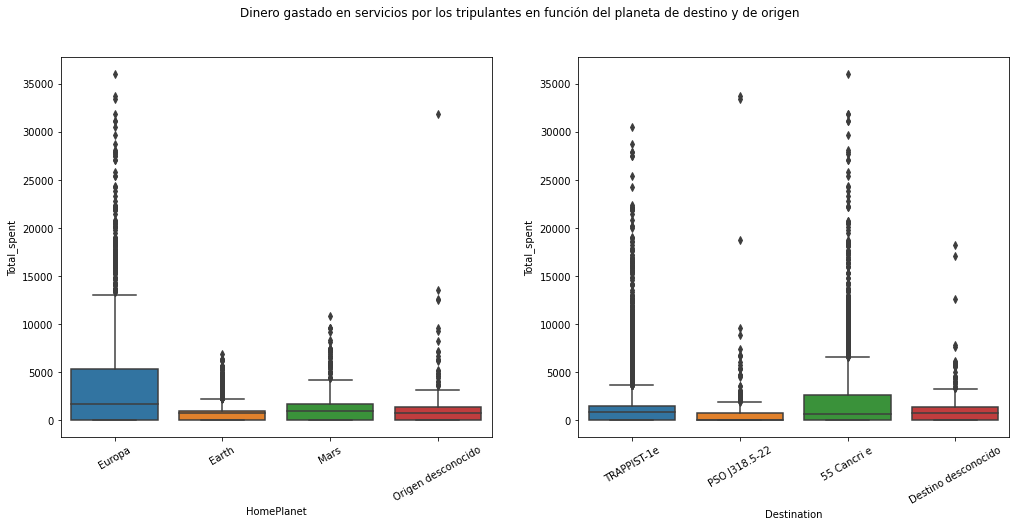

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

fig.suptitle('Dinero gastado en servicios por los tripulantes en función del planeta de destino y de origen')


ax=sns.boxplot(ax=axes[0], x='HomePlanet', y='Total_spent', data=titanic)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax=sns.boxplot(ax=axes[1], x='Destination', y='Total_spent', data=titanic)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

En cuanto al **planeta de origen**, destaca con diferencia las cantidades gastadas en servicios por las personas provenientes de *Europa*. No solo el rango intercuartílico recoge el rango de valores más altos que el resto si no que además, cuenta con una gran cantidad de outliers que corresponden a personas que han llegado a gastarse cantidades superiores a los 25.000 euros (asumiendo que esa sea la moneda utilizada). Las personas que menos se han gastado en general son aquellas provenientes de la Tierra, a pesar de que como observamos al analizar los planetas de origen, la mayoría de tripulantes eran terrícolas.

En cuanto a la división por **planeta de destino**, podemos ver que los gastos están un poco más diversificados, no existe tanta diferenciación. Los tripulantes que se dirigen a *55 Cancri e* parecen gastar más pero realmente cuentan con un nivel más alto de dispersión debido a la gran cantidad de outliers presentes en los datos de este grupo.

Finalmente, observaremos la media de gastos divididos en cada uno de los diferentes servicios en función de la edad, con el objetivo de identificar posibles tendencias.

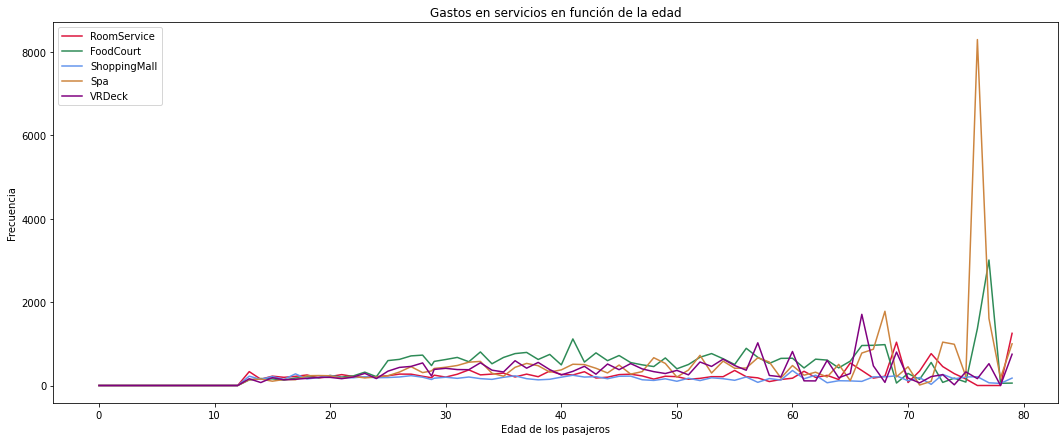

In [166]:
plt.figure(3,figsize=(24,7)) 

room_age=titanic.groupby('Age')['RoomService'].mean()
food_age=titanic.groupby('Age')['FoodCourt'].mean()
shopping_age=titanic.groupby('Age')['ShoppingMall'].mean()
spa_age=titanic.groupby('Age')['Spa'].mean()
vdeck_age=titanic.groupby('Age')['VRDeck'].mean()

plt.plot(room_age, color='crimson', label='RoomService')
plt.plot(food_age, color='seagreen', label='FoodCourt')
plt.plot(shopping_age, color='cornflowerblue', label='ShoppingMall')
plt.plot(spa_age, color='peru', label='Spa')
plt.plot(vdeck_age, color='purple', label='VRDeck')

plt.ylabel('Frecuencia')
plt.xlabel('Edad de los pasajeros')
plt.title("Gastos en servicios en función de la edad")
plt.legend(loc='upper left')
plt.show()

Es evidente que hasta los 13 años no se comienzan a tener gastos relacionados con los servicios. A partir de esa edad, los gastos son bastante bajos y uniformes (no hay un servicio que destaque por encima de los otros). A partir de los 24-25 años de edad, comienza un aumento de los gastos en servicios extra especialmente el de restauración (*FoodCourt*). En general ,los gastos medios más pequeños son realizados en compras en el centro comercial mientras que los gastos en comida son los más recurrentes a lo largo de todas las edades. Parece ser bastante común también el gasto en *VRDeck* especialmente entre las edades de 55-70 años y el gasto en *Spa* entre las edades de entre 65 y 80 años. Es llamativa la cantidad de dinero gastado en el rango de edad 72-77 años en este servicio, tal y como podemos observar en el pico amarillo de la derecha.

Toda esta información relativa a gastos de los tripulantes podría utilizarse para realizar una segmentación de clientes y saber a qué tipo de cliente promocionar los servicios de la nave.

<AxesSubplot:title={'center':'Matriz de correlación de variables numéricas'}>

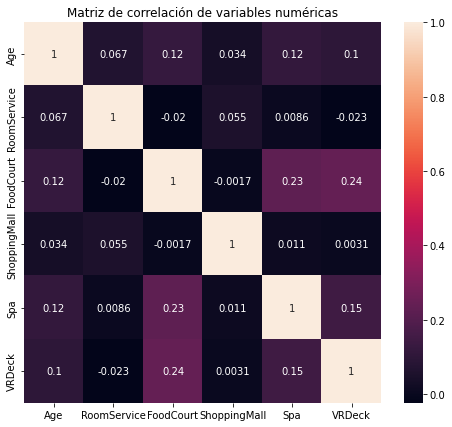

In [167]:
plt.figure(3,figsize=(10,7))

corr = titanic[col_numeric].corr()

plt.title('Matriz de correlación de variables numéricas')
sns.heatmap(corr,  annot=True)


Por último, hemos dibujado una matriz de correlación entre las variables numéricas para ver hasta que punto podemos decir que están correlacionadas. Observamos que en general no existe una correlación muy alta entre las variables numéricas. Las correlaciones más altas se dan entre las variables **Spa** y **FoodCourt**, que son los gastos más recurrentes como hemos visto anteriormente y entre **VRDeck** y **FoodCourt**. Los gastos más correlacionados con la edad son precisamente los primeros comentados, **Spa** y **FoodCourt**.

A continuación, como se ha comentado anteriormente vamos a analizar la variable objetivo en el conjunto del dataset.

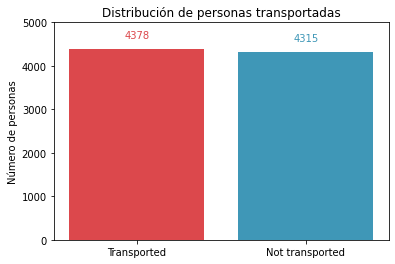

In [120]:
fig, ax = plt.subplots()
labels = ['Transported', 'Not transported']
color=['#dc484c',  '#3f97b7']

bar=ax.bar(labels, titanic_train['Transported'].value_counts(), color=color)
ax.set_title('Distribución de personas transportadas')
ax.set_ylim(0,5000)
ax.set_ylabel('Número de personas')

def autolabel(rects):
    # attach some text labels
    for rect, col in zip(rects, color):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom', color=col)

autolabel(bar)

Podemos ver que la variable objetivo está muy balanceada. Esto puede evitar numerosos problemas en un futuro a la hora del análisis y de las pruebas estadísticas. Además, en caso de llegar a entrenar un algoritmo de clasificación por ejemplo, el hecho de que la variable de clasificación esté balanceada hará que se eviten sesgos en el entrenamiento del algoritmo.

<AxesSubplot:title={'center':'Transported = 1'}, ylabel='CryoSleep'>

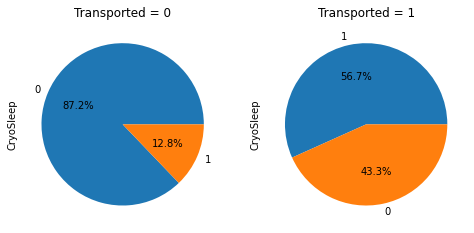

In [121]:
# En funcion de si los pasajeros estaban criogenizados o no
fig, axs = plt.subplots(1, 2, figsize=(8,6))
titanic_train[titanic_train['Transported'] == 0]['CryoSleep'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 0',
                                                                         ax=axs[0])

titanic_train[titanic_train['Transported'] == 1]['CryoSleep'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 1',
                                                                         ax=axs[1])

<AxesSubplot:title={'center':'Transported = 1'}, ylabel='Destination'>

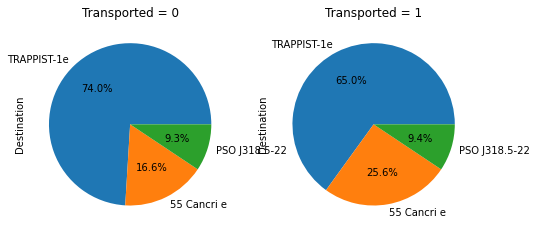

In [122]:
# En funcion del destino de los pasajeros
fig, axs = plt.subplots(1, 2, figsize=(8,6))
titanic_train[titanic_train['Transported'] == 0]['Destination'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 0',
                                                                         ax=axs[0])

titanic_train[titanic_train['Transported'] == 1]['Destination'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 1',
                                                                         ax=axs[1])

<AxesSubplot:title={'center':'Transported = 1'}, ylabel='VIP'>

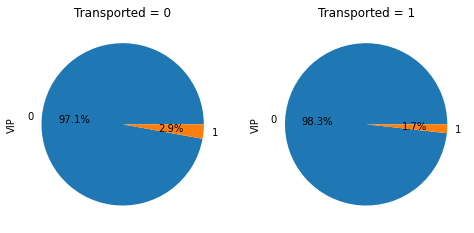

In [123]:

# En funcion de si los pasajeros eran de clase VIP o no
fig, axs = plt.subplots(1, 2, figsize=(8,6))
titanic_train[titanic_train['Transported'] == 0]['VIP'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 0',
                                                                         ax=axs[0])

titanic_train[titanic_train['Transported'] == 1]['VIP'].value_counts().plot(kind='pie', 
                                                                         autopct='%1.1f%%', 
                                                                         title='Transported = 1',
                                                                         ax=axs[1])

## 5.2. Análisis estadístico

En la siguiente sección se realizará un análisis del dataset desde un enfoque más estadístico.

### 5.2.1 Análisis estadístico descriptivo

Comenzaremos por analizar las distribuciones de las diferentes variables numéricas, así como los valores máximos, mínimos, la media la moda y el rango intercuartílico. Vamos a ver la distribución de las variables en forma de gráficos de cajas. En el caso de las variables relacionadas con los gastos, se ha incluído un límite en el eje X para una visualización más clara, debido a la existencia de muchos outliers. Los máximos de cada variable sin embargo pueden verse en la tabla posterior.

[(-100.0, 2000.0)]

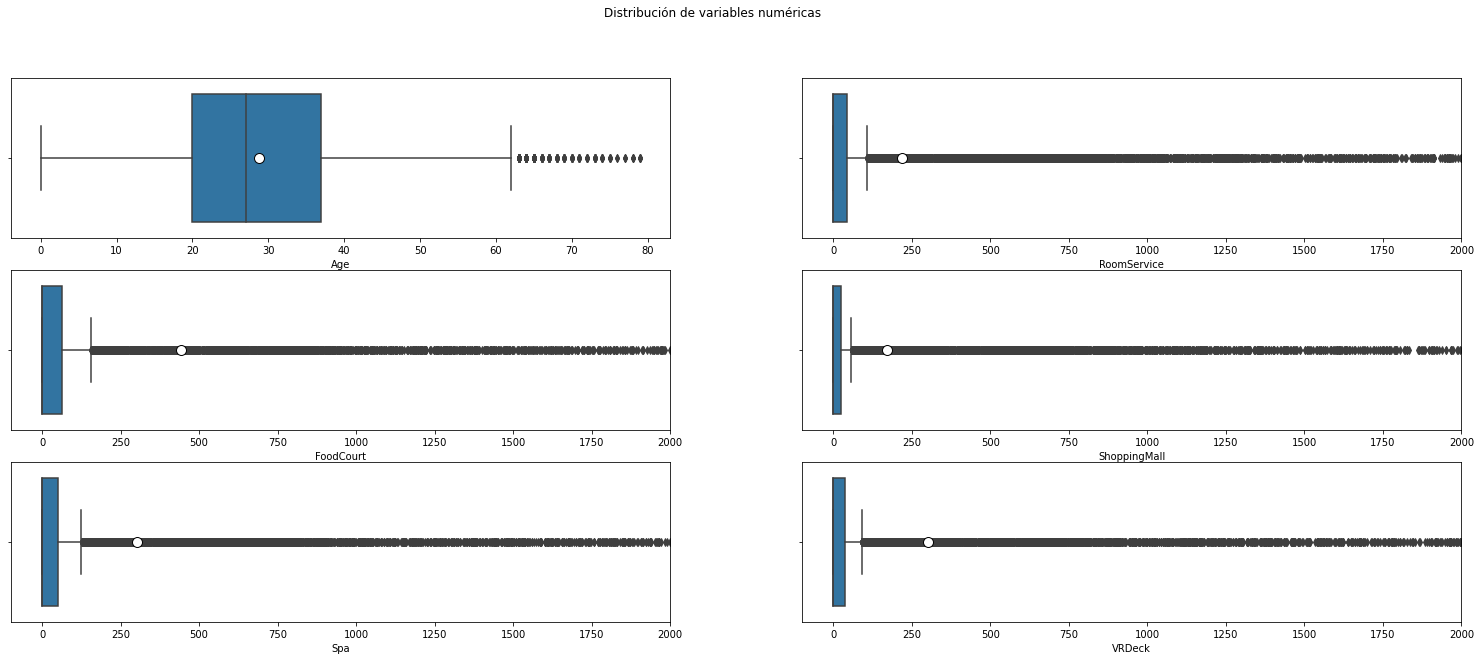

In [163]:
fig, axes = plt.subplots(3, 2, figsize=(26, 10))

fig.suptitle('Distribución de variables numéricas')


sns.boxplot(ax=axes[0, 0], data=titanic, x='Age', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"})
sns.boxplot(ax=axes[0, 1], data=titanic, x='RoomService', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[1, 0], data=titanic, x='FoodCourt', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[1, 1], data=titanic, x='ShoppingMall', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[2, 0], data=titanic, x='Spa', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
sns.boxplot(ax=axes[2, 1], data=titanic, x='VRDeck', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black","markersize":"10"}).set(xlim=(-100, 2000))
            

In [165]:
titanic[col_numeric].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.771969,218.378026,441.890979,170.779491,301.722282,300.450270
std,14.236710,641.766201,1568.038076,584.153630,1118.746785,1168.655639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,42.750000,62.750000,23.000000,50.000000,36.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


En el caso de la **edad**, podemos ver que el 50% de la población más central se encuentra entre los 20 y los 27 años de edad, por lo que la mayoría de los tripulantes son bastante jóvenes. Los datos forman una distribución bastante simética, exceptuando una serie de outliers por la derecha formada por gente mayor de 63 años, lo cual hace que la media suba y por tanto rompe con la simetría. El máximo de edad se encuentra en los 79 años, con lo cual concluimos que en comparación con la esperanza de vida actual, se trata de una población poco longeva.

El resto de las variables relativas a los gastos tienen una forma bastante similar, por lo que las comentaremos a la vez. Se caracterizan por una distribución nada simétrica, en la que la gran mayoría de valores se concentran al principio, de manera que se forma en todas una larga cola por la parte derecha formada por valores considerados outliers. La gran mayoría de genre no suele gastarse grandes cantidades de dinero en los servicios de la nave, ya que en ninguno de los servicios el 75% de los valores más comunes excede los 70 euros. No obstante, las medias de todas las variables se ven muy perjudicadas por la gran cantidad de outliers, al no ser una medida robusta de tendencia central. En resumen, existen muchas personas que se gastan poco en servicios, en contraste con unas pocas personas que se gastan mucho en servicios. En el caso del *Spa* por ejemplo, mientras la gran mayoría de personas no han excedido un gasto de 50 euros, en otras personas las cantidades gastadas superan los 22.000 euros. Fijándonos en la media, el servicio en el que la gente suele gastarse más dinero es em **FoodCourt**.


### 5.2.2. Comprobación de la normalidad y homogeneidad de la varianza

Realizaremos la comprobación de la normalidad y homocedasticidad entre las varianzas de los diferentes grupos que consideremos interesantes, de cara a poder realizar contrastes de hipótesis en el siguiente apartado.


### 5.2.3. Aplicación de pruebas estadísticas

En función de lo que hemos observado durante el análisis exploratorio descriptivo, vamos a realizar tres pruebas estadísticas.

#### Correlación entre planeta de origen y si ha sido transportado

Queremos comprobar si las variables **HomePlanet** y **Transported** son dependientes es decir, si influye o no el país de origen del individuo a la hora de predecir si será teletransportado a otra dimensión o no. Al tratarse de dos variables categóticas, utilizaremos la prueba de chi-cuadrado de Pearson. Este test nos permite realizar una prueba de independencia entre ambas variables. 

En primer lugar, calcularemos una tabla de contingencia para resumir la relación entre ambas variables. Podemos ver la cantidad de personas que han sido transportadas y las que no provenientes de cada país de origen.


In [124]:
contingency=pd.crosstab(titanic_train['HomePlanet'],
                            titanic_train['Transported'], 
                            margins = False)
pd.crosstab(titanic_train['HomePlanet'], titanic_train['Transported'],  margins = True)

Transported,0,1,All
HomePlanet,,,
Earth,2651,1951,4602
Europa,727,1404,2131
Mars,839,920,1759
All,4217,4275,8492


In [125]:
chi_val, p, dof, expected = chi2_contingency(contingency)
print(f'chi value:\t\t{chi_val}\np-value:\t\t {p}\ndegrees of freedom:\t {dof}\nexpected values:\n{expected}\n')

print('_______Resultados del test Chi cuadrado_______')
if p <= 0.05:
    print('Variables dependientes (rechazo de H0)')
else:
    print('Variables independientes (aceptación de H0)')

chi value:		324.9013834000382
p-value:		 2.809059985251311e-71
degrees of freedom:	 2
expected values:
[[2285.28426755 2316.71573245]
 [1058.22268017 1072.77731983]
 [ 873.49305228  885.50694772]]

_______Resultados del test Chi cuadrado_______
Variables dependientes (rechazo de H0)


Una vez realizado el test, analizamos los resultados obtenidos. En el caso del test de Chi cuadrado, la hipótesis nula ($H_0$) establece que no existe relación entre las variables. Por el contrario, la hipótesis alternativa ($H_0$) afirmaría que existe una relación significativa entre ambas. Observando el p-valor resultante, vemos que se trata de un valor muy cercano a 0, inferior al nivel de significancia 0.05. Por tanto, el error de descartar $H_0$ sería muy bajo. Se entiende por tanto que el valor resultado del test 324.90 es mayor al valor crítico, cayendo en la zona de rechazo de la hipótesis nula. Podemos afirmar entonces que las variables **HomePlanet** y **Transported** son dependientes.

#### Intervalos de confianza de la media de edad

En la siguiente prueba estadística, nos interesa calcular el intervalo de confianza de la edad de los pasajeros. Partimos de la base de que este dataset contiene información de una muestra de pasajeros pertenecientes a una población más grande. Tanto la media $\mu$ como la desviación típica $\sigma$ de la población se asumen como desconocidas. Es por esto que nos interesa conocer el intervalo de confianza en el que se encuentra la media de edad de la población, calculándolo a partir de la muestra. Sin embargo, debido a que no podemos tener la certeza absoluta de que eso se cumpla para todos los casos (es decir, todas las muestras seleccionadas de la población), se utiliza el *nivel de confianza*. EN nuestro caso, calcularemos los intervalos de confianza de la media de edad entre las personas **transportadas** y las **no transportadas**, y realizaremos una comparación entre ambos intervalos.

Vamos a empezar separando ambos grupos de estudio.

In [260]:
age_transported = titanic['Age'][titanic['Transported']==1]
age_non_transported = titanic['Age'][titanic['Transported']==0]

En primer luugar, estudiaremos la normalidad de cada uno de los grupos por separado. Para ello representaremos los datos mediante un histograma superponiendo la curva de una distribución normal con la misma media y desviación estándar de cada conjunto.

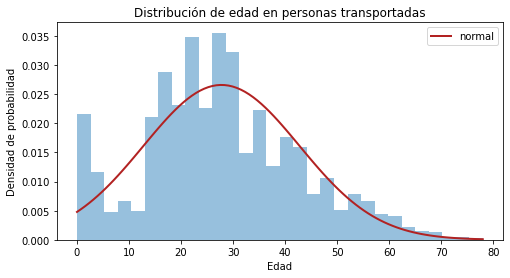

In [216]:
mu, sigma = stats.norm.fit(age_transported)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(age_transported), max(age_transported), num=100)
y_hat = scipy.stats.norm.pdf(x_hat, mu, sigma)


# Graficas de distribución
fig, axes = plt.subplots(figsize=(8,4))


plt.plot(x_hat, y_hat, linewidth=2, label='normal', color='firebrick')
plt.hist(x=age_transported, density=True, bins=30, color="#3182bd", alpha=0.5)
plt.title('Distribución de edad en personas transportadas')
plt.xlabel('Edad')
plt.ylabel('Densidad de probabilidad')
plt.legend()


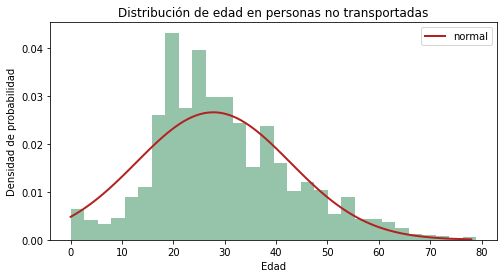

In [215]:
fig, axes = plt.subplots(figsize=(8,4))

plt.plot(x_hat, y_hat, linewidth=2, label='normal', color='firebrick')
plt.hist(x=age_non_transported, density=True, bins=30, color="seagreen", alpha=0.5)
plt.title('Distribución de edad en personas no transportadas')
plt.xlabel('Edad')
plt.ylabel('Densidad de probabilidad')
plt.legend()

Podemos ver que a grandes rasgos, ambas gráficas parecen asemejarse a una distribución normal, pero cuentan con picos muy altos que se salen de la distribución esperada. En el caso de las personas trasnportadas, existe además otro pico de densidad entre las personas más jóvenes de entre 0 y 5 años.

Utilizaremos también gráficos de cuantiles teóricos (Gráficos Q-Q) para realizar una comparación más precisa de la normalidad.

Text(0.5, 1.0, 'Gráfico Q-Q de la edad de las personas transportadas')

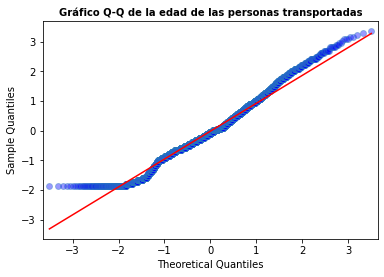

In [254]:
sm.qqplot(age_transported,fit= True,line ='q',alpha = 0.4,lw= 2, color="#3182bd", fmt="#3182bd")
plt.title('Gráfico Q-Q de la edad de las personas transportadas', fontsize = 10, fontweight = "bold")

Text(0.5, 1.0, 'Gráfico Q-Q de la edad de las personas no transporttadas')

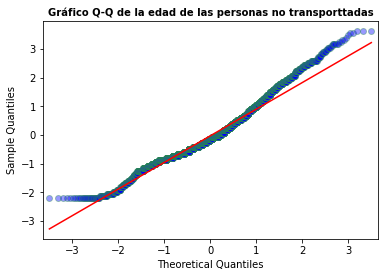

In [253]:
sm.qqplot(age_non_transported,fit= True,line ='q',alpha = 0.4,lw= 2,color="seagreen")
plt.title('Gráfico Q-Q de la edad de las personas no transportadas', fontsize = 10, fontweight = "bold")

Para poder decir que los datos siguen una distribución normal, los puntos deberían estar alineados en torno a la recta. Podemos ver que a pesar de que hay zonas en las que coincide, en ninguno de los dos casos se cumple esta alineación de manera evidente, especialmente en en caso de las personas no transportadas. Podemos asumir por tanto que a pesar de que se acercan, **ninguna de los dos grupos sigue una distribución normal**.


Según el Teorema del Límite Central, las medias de las muestras de una población siguen una distribución normal aunque la población no tenga una distribución normal, siempre que el tamaño de las muestras sea suficientemente grande. De este modo, teniendo en cuenta el Teorema del Límite Central y dado que el tamaño de la muestra es lo suficientemnte grande (n > 30), se puede asumir normalidad en la variable. Sin embargo, dado que no se conoce la varianza de la población, la estimaremos a partir de la muestra. Esto significa que usaremos la distribución t de Student en lugar de la distribución normal.

Para calcular el intervalo de confianza en ambos grupos, crearemos una función que recibe los datos y el nivel de confianza.

In [277]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f"Mean: {round(m,4)}     Confidence interval:  ({round(m-h,4)}, {round(m+h,4)})"

In [278]:
mean_confidence_interval(age_transported, 0.95)

'Mean: 27.7699     Confidence interval:  (27.3255, 28.2142)'

In [279]:
mean_confidence_interval(age_non_transported, 0.95)

'Mean: 29.8991     Confidence interval:  (29.4945, 30.3038)'

Los resultados obtenidos son:

- El intervalo de confianza al 95% de la media de la variable **Age** para las personas transportadas es (27.3255, 28.2142)
- El intervalo de confianza al 95% de la media de la variable **Age** para las personas no transportadas es (29.4945, 30.3038)

Esto significa que, 95 de cada 100 veces que escojamos una muestra aleatoria simple de pasajeros transportados y calculemos el valor de la media muestral nos dará un valor comprendido en el intervalo (27.3255, 28.2142). En el caso del otro grupo, 95 de cada 100 veces que escojamos una muestra aleatoria simple de pasajeros no transportados y calculemos el valor de la media muestral nos dará un valor comprendido en el intervalo 29.4945, 30.3038).

El intervalo de confianza de la media de las personas transportadas comprende un rango de valores un poco más grande que el de las personas no transportadas. Podemos ver que no existe solapamiento entre los intervalos de confianza de las medias muestrales. Además como puede observarse, el de las personas no transportadas recoge valores más altos. Esto quiere decir que, con una confianza del 95% podríamos llegar a intuir que las personas no transportadas son de media más mayores que las personas transportadas. No obstante, para poder corroborar esto de manera fiable tendríamos que realizar un contraste de hipótesis entre las medias de ambas muestras.

# 6. Conclusiones

Finalmente se expondrán las conclusiones obtenidas durante todo el proceso de análisis.

OPCION 1 - ALICIA
- Análisis exploratorio 
    -- Análisis descriptivo (analisis general)
    -- Análisis estadístico
        --- Análisis estadístico descriptivo
        --- Aplicación de pruebas estadísticas
            + Prueba 1
            + Prueba 2


OPCION 2 - DANI
- Análisis exploratorio 
    -- Análisis descriptivo (analisis variable objetivo)
    -- Análisis estadístico
        --- Comprobación de la normalidad y homogeneidad de la varianza
        --- Aplicación de pruebas estadísticas
            + Prueba 3
- Resumir las conclusiones